In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from torch.utils.data import TensorDataset, DataLoader
import math
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using device: cuda
PyTorch version: 2.8.0+cu126
CUDA available: True


In [221]:
class ChebySigmoidActivation(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n

    def get_n_value(self):
        return self.n

    def forward(self, x):
        sigmoid_val = torch.sigmoid(x)
        tanh_beta_val = torch.tanh(self.beta * x)
        safe_tanh_beta_val = torch.clamp(tanh_beta_val, -1 + 1e-6, 1 - 1e-6)
        out = sigmoid_val + self.alpha * torch.cos(self.n * torch.acos(safe_tanh_beta_val)) * sigmoid_val * (1 - sigmoid_val)
        return out

class ChebyTanhActivation(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n

    def get_n_value(self):
        return self.n

    def forward(self, x):
        tanh_beta_val = torch.tanh(self.beta * x)
        tanh_val = torch.tanh(x)
        sech_val = (1 / torch.cosh(x)) ** 2
        safe_tanh_beta_val = torch.clamp(tanh_beta_val, -1 + 1e-6, 1 - 1e-6)
        out = tanh_val + self.alpha * torch.cos(self.n * torch.acos(safe_tanh_beta_val)) * sech_val
        return out

In [222]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM Parameters
        self.weight_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.zeros(4 * hidden_size))


        # Custom Activation Functions
        self.sigmoid_activation = ChebySigmoidActivation(alpha=alpha, beta=beta, n=n)
        self.tanh_activation = ChebyTanhActivation(alpha=alpha, beta=beta, n=n)

        # Add batch normalization
        #self.bn_ih = nn.BatchNorm1d(4 * hidden_size)
        #self.bn_hh = nn.BatchNorm1d(4 * hidden_size)
        #self.bn_c = nn.BatchNorm1d(hidden_size)

    def forward(self, input, hx):
        h_prev, c_prev = hx
        batch_size = input.size(0)

        # Compute gates with batch normalization
        ih = F.linear(input, self.weight_ih, self.bias_ih)
        hh = F.linear(h_prev, self.weight_hh, self.bias_hh)

        gates = ih + hh

        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)

        # Apply Chebyshev activations to gates
        forgetgate = self.sigmoid_activation(forgetgate)
        ingate = self.sigmoid_activation(ingate)
        cellgate_candidate = self.tanh_activation(cellgate)
        outgate = self.sigmoid_activation(outgate)

        # Update cell state
        c_next = forgetgate * c_prev + ingate * cellgate_candidate

        # Apply batch norm to cell state if batch size > 1
        #if batch_size > 1:
        #    c_next = self.bn_c(c_next)

        # Update hidden state
        h_next = outgate * self.tanh_activation(c_next)

        return h_next, (h_next, c_next)

    def get_n_values(self):
        return {
            'sigmoid_n': self.sigmoid_activation.get_n_value(),
            'tanh_n': self.tanh_activation.get_n_value()
        }

In [223]:
import torch
import torch.nn as nn

class BaselineMultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, target_size=1, num_layers=1, dropout=0.0, bidirectional=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.target_size = target_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional,
        )
        lstm_out_dim = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(lstm_out_dim, target_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)          # (batch, seq_len, hidden)
        last_output = out[:, -1, :]  # Get the output from the last time step
        out = self.fc(last_output)     # (batch, target_size)
        return out

    # Keep API compatibility with your existing training/printing
    def get_n_values(self):
        # No custom n in baseline; return zeros so downstream logging works
        return torch.zeros(1)

In [224]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.cell = CustomLSTMCell(input_size, hidden_size, alpha=alpha, beta=beta, n=n)
        self.hidden_size = hidden_size

    def forward(self, inputs, hx=None):
        # Handle batch_first=True for convenience
        # Expected input shape: [batch_size, seq_len, features]
        inputs = inputs.transpose(0, 1)  # Convert to [seq_len, batch_size, features]

        if hx is None:
            batch_size = inputs.size(1)
            h_0 = torch.zeros(batch_size, self.cell.hidden_size, device=inputs.device)
            c_0 = torch.zeros(batch_size, self.cell.hidden_size, device=inputs.device)
            hx = (h_0, c_0)

        h, c = hx
        outputs = []

        for t in range(inputs.size(0)):
            h, (h, c) = self.cell(inputs[t], (h, c))
            outputs.append(h)

        outputs = torch.stack(outputs)
        # Convert back to batch_first format
        outputs = outputs.transpose(0, 1)
        return outputs, (h, c)

    def get_n_values(self):
        return self.cell.get_n_values()

In [225]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.lstm = CustomLSTM(input_size, hidden_size, alpha=alpha, beta=beta, n=n)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size, output_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.xavier_uniform_(module.weight)
            if module.bias is not None:
                init.constant_(module.bias, 0)
        elif isinstance(module, CustomLSTMCell):
            init.xavier_uniform_(module.weight_ih)
            init.xavier_uniform_(module.weight_hh)
            init.constant_(module.bias_ih, 0)
            init.constant_(module.bias_hh, 0)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        predictions = self.linear(last_output)
        return predictions

    def get_n_values(self):
        return self.lstm.get_n_values()

In [226]:
def create_multivariate_sequences(data, seq_length, feature_column_idx=None, target_column_idx=None):
    """
    Create input/output sequences from multivariate time series data

    Parameters:
    - data: numpy array of shape (samples, features)
    - seq_length: number of time steps to look back
    - feature_column_idx: index or list of indices of features to use for prediction
    - target_column_idx: which feature to predict

    Returns:
    - X: input sequences
    - y: target values
    """
    xs, ys = [], []

    # Convert feature_column_idx to list if it's a single index
    if feature_column_idx is not None and not isinstance(feature_column_idx, list):
        feature_column_idx = [feature_column_idx]

    for i in range(len(data) - seq_length):
        # Input sequence
        if feature_column_idx is not None:
            # Use only specified feature columns
            x = data[i:i+seq_length, feature_column_idx]
        else:
            # Use all features
            x = data[i:i+seq_length]

        # Output value
        if target_column_idx is not None:
            y = data[i+seq_length, target_column_idx:target_column_idx+1]
        else:
            # Default to predicting all variables
            y = data[i+seq_length]

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


def prepare_multivariate_data(data, seq_length=20, train_ratio=0.8, batch_size=32,
                             feature_column_idx=None, target_column_idx=None):
    """
    Prepare multivariate time series data for LSTM training

    Parameters:
    - data: pandas DataFrame or numpy array with multiple columns
    - seq_length: number of time steps to look back
    - train_ratio: proportion of data to use for training
    - batch_size: batch size for training
    - feature_column_idx: index or list of indices of features to use for prediction
    - target_column_idx: which feature to predict

    Returns:
    - Dictionary with data loaders, scalers, and other information
    """
    # Convert to numpy array if needed
    if isinstance(data, pd.DataFrame):
        column_names = data.columns
        data = data.values
    else:
        column_names = [f"Feature_{i}" for i in range(data.shape[1])]

    # Store original shape
    n_samples, n_features = data.shape
    print(f"Data shape: {n_samples} samples, {n_features} features")

    # Determine output size
    output_size = 1 if target_column_idx is not None else n_features

    # Determine input size
    if feature_column_idx is not None:
        if isinstance(feature_column_idx, list):
            input_size = len(feature_column_idx)
        else:
            input_size = 1
    else:
        input_size = n_features

    print(f"Using {input_size} input feature(s) to predict {output_size} output(s)")

    # Scale the data - fit scaler on training portion to avoid data leakage
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)

    # Scale all data
    data_scaled = scaler.transform(data)
    if np.isnan(data_scaled).any():
        print("NaNs found in the data AFTER scaling!")
    # This indicates an issue with the original data or the scaler

    # Create sequences
    X, y = create_multivariate_sequences(data_scaled, seq_length, feature_column_idx, target_column_idx)

    # Split into train and test sets
    X_train, X_test = X[:train_size-seq_length], X[train_size-seq_length:]
    y_train, y_test = y[:train_size-seq_length], y[train_size-seq_length:]

    print(f"Created {len(X)} sequences with length {seq_length}")
    print(f"Training set: {len(X_train)} sequences, Test set: {len(X_test)} sequences")
    print(f"Input shape: {X.shape}, Output shape: {y.shape}")

    # Convert to PyTorch tensors and move to device
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).to(device)

    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'train_loader': train_loader,
        'test_loader': test_loader,
        'scaler': scaler,
        'data': data,
        'scaled_data': data_scaled,
        'train_size': train_size,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'seq_length': seq_length,
        'column_names': column_names,
        'output_size': output_size,
        'input_size': input_size,
        'feature_column_idx': feature_column_idx,
        'target_column_idx': target_column_idx
    }

In [227]:
import torch
import torch.nn.functional as F

# ==========================
# 📌 KL Divergence / Beta Divergence (β = 1)
# ==========================
def beta_divergence(p, q, beta=1):
    """
    Computes Beta Divergence. For beta=1, it becomes KL Divergence.
    p = model prediction
    q = ground truth
    """
    p = torch.clamp(p, min=1e-8)  # Avoid log(0)
    q = torch.clamp(q, min=1e-8)

    if beta == 1:  # KL Divergence
        return torch.mean(q * torch.log(q / p) - q + p)

    elif beta == 0:  # Itakura-Saito
        return torch.mean((q / p) - torch.log(q / p) - 1)

    else:  # General Beta divergence
        return torch.mean((q**beta + (beta - 1) * p**beta - beta * q * (p**(beta - 1))) /
                          (beta * (beta - 1)))


# ==========================
# 📌 Jensen-Shannon Divergence (JSD)
# ==========================
def jensen_shannon_divergence(p, q):
    """
    Computes Jensen-Shannon Divergence between p and q.
    """
    p = torch.clamp(p, min=1e-8)
    q = torch.clamp(q, min=1e-8)
    m = 0.5 * (p + q)
    return 0.5 * (F.kl_div(torch.log(p), m, reduction='batchmean') +
                  F.kl_div(torch.log(q), m, reduction='batchmean'))


In [228]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, epochs=100, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.MSELoss()  # ✅ Main Loss: MSE
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    train_losses = []
    test_losses = []
    sigmoid_n_values = []
    tanh_n_values = []
    beta_values = []
    jsd_values = []

    print(f"\n🚀 Starting training for {epochs} epochs on {device}...\n")

    # Check if the model is the custom LSTM
    is_custom_lstm_model = isinstance(model, MultivariateLSTM) # Check against the custom model class

    for epoch in range(epochs):
        model.train()
        train_loss = 0.
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            # print(f"Shape of y_pred: {y_pred.shape}") # Removed debugging print
            # print(f"Shape of y_batch: {y_batch.shape}") # Removed debugging print
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Track Chebyshev activation parameters "n" only if using the custom LSTM
        if is_custom_lstm_model:
            n_values = model.get_n_values()
            sigmoid_n_values.append(n_values['sigmoid_n'])
            tanh_n_values.append(n_values['tanh_n'])
        else:
            # Append placeholders if not using custom LSTM
            sigmoid_n_values.append(float('nan'))
            tanh_n_values.append(float('nan'))


        # -------------------
        # 🧪 EVALUATION LOOP
        # -------------------
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X_test, y_test in test_loader:
                preds = model(X_test)
                test_loss += criterion(preds, y_test).item()
                all_preds.append(preds)
                all_targets.append(y_test)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        p = torch.cat(all_preds, dim=0)
        q = torch.cat(all_targets, dim=0)

        beta_val = beta_divergence(p, q, beta=1).item()  # KL
        jsd_val = jensen_shannon_divergence(p, q).item()  # JSD

        beta_values.append(beta_val)
        jsd_values.append(jsd_val)

        scheduler.step(test_loss)

        print_str = f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | KL: {beta_val:.4f} | JSD: {jsd_val:.4f}"
        if is_custom_lstm_model:
             n_values = model.get_n_values() # Get n_values again for printing
             print_str += f" | n_sigmoid: {n_values['sigmoid_n']:.4f} | n_tanh: {n_values['tanh_n']:.4f}"
        print(print_str)


    print("\n✅ Training Completed.\n")

    if len(beta_values) == 1:
        plt.plot(beta_values, marker='o', label='KL Divergence (Beta=1)')
        plt.plot(jsd_values, marker='o', label='JSD Divergence')
    else:
        plt.plot(beta_values, label='KL Divergence (Beta=1)')
        plt.plot(jsd_values, label='JSD Divergence')

    plt.xlabel("Epochs")
    plt.ylabel("Divergence")
    plt.title("Divergence Over Epochs (Test Data)")
    plt.legend()
    plt.grid(True)
    plt.show()


    avg_beta = sum(beta_values) / len(beta_values)
    avg_jsd = sum(jsd_values) / len(jsd_values)

    print("=== Average Divergence Metrics ===")
    print(f"Average KL (Beta=1): {avg_beta:.6f}")
    print(f"Average JSD        : {avg_jsd:.6f}")

    return train_losses, test_losses, sigmoid_n_values, tanh_n_values

In [229]:
def predict_all_data(model, data_dict):
    """
    Make predictions for both training and testing data
    """
    model.eval()

    # Predict on training data
    with torch.no_grad():
        train_predictions_scaled = model(data_dict['X_train']).cpu().numpy()
        test_predictions_scaled = model(data_dict['X_test']).cpu().numpy()

    # Get actual values
    train_actual_scaled = data_dict['y_train'].cpu().numpy()
    test_actual_scaled = data_dict['y_test'].cpu().numpy()

    # Prepare containers for inverse-transformed data
    # The shape should match the scaled predictions/actuals
    train_predictions = np.zeros_like(train_predictions_scaled)
    test_predictions = np.zeros_like(test_predictions_scaled)
    train_actual = np.zeros_like(train_actual_scaled)
    test_actual = np.zeros_like(test_actual_scaled)

    # Inverse transform
    scaler = data_dict['scaler']
    num_features = data_dict['data'].shape[1] # Total number of features in the original data

    # If we're predicting a single target variable
    if data_dict['target_column_idx'] is not None:
        target_idx = data_dict['target_column_idx']

        # Prepare dummy arrays for inverse transform with the correct number of features
        dummy_train_pred = np.zeros((train_predictions_scaled.shape[0], num_features))
        dummy_test_pred = np.zeros((test_predictions_scaled.shape[0], num_features))
        dummy_train_actual = np.zeros((train_actual_scaled.shape[0], num_features))
        dummy_test_actual = np.zeros((test_actual_scaled.shape[0], num_features))

        # Fill dummy arrays with the predicted values at the correct target column index
        dummy_train_pred[:, target_idx:target_idx+1] = train_predictions_scaled
        dummy_test_pred[:, target_idx:target_idx+1] = test_predictions_scaled
        dummy_train_actual[:, target_idx:target_idx+1] = train_actual_scaled
        dummy_test_actual[:, target_idx:target_idx+1] = test_actual_scaled

        # Inverse transform the dummy arrays
        train_pred_full = scaler.inverse_transform(dummy_train_pred)
        test_pred_full = scaler.inverse_transform(dummy_test_pred)
        train_actual_full = scaler.inverse_transform(dummy_train_actual)
        test_actual_full = scaler.inverse_transform(dummy_test_actual)

        # Extract the target column from the inverse-transformed full data
        train_predictions = train_pred_full[:, target_idx:target_idx+1]
        test_predictions = test_pred_full[:, target_idx:target_idx+1]
        train_actual = train_actual_full[:, target_idx:target_idx+1]
        test_actual = test_actual_full[:, target_idx:target_idx+1]
    else:
        # If predicting all variables, directly inverse transform
        # The model output shape should match the number of features
        if train_predictions_scaled.shape[1] != num_features:
             raise ValueError(f"Model output size ({train_predictions_scaled.shape[1]}) does not match original number of features ({num_features}). Cannot inverse transform directly.")

        train_predictions = scaler.inverse_transform(train_predictions_scaled)
        test_predictions = scaler.inverse_transform(test_predictions_scaled)
        train_actual = scaler.inverse_transform(train_actual_scaled)
        test_actual = scaler.inverse_transform(test_actual_scaled)


    return {
        'train_predictions': train_predictions,
        'train_actual': train_actual,
        'test_predictions': test_predictions,
        'test_actual': test_actual,
        'train_predictions_scaled': train_predictions_scaled,
        'train_actual_scaled': train_actual_scaled,
        'test_predictions_scaled': test_predictions_scaled,
        'test_actual_scaled': test_actual_scaled
    }

In [230]:
def predict_and_visualize_multivariate(model, data_dict, title='Multivariate Time Series Forecasting'):
    """
    Visualization for multivariate time series predictions
    """
    # Get predictions
    predictions = predict_all_data(model, data_dict)

    # Determine if we're predicting single or multiple targets
    is_single_target = data_dict['target_column_idx'] is not None
    target_idx = data_dict['target_column_idx'] if is_single_target else None

    # Get target name(s)
    if is_single_target:
        target_name = data_dict['column_names'][target_idx]
        target_names = [target_name]
    else:
        target_names = data_dict['column_names']

    # Calculate RMSE for each target
    train_rmse_values = []
    test_rmse_values = []
    train_rmse_scaled_values = []
    test_rmse_scaled_values = []

    # Create sequence indices for plotting
    seq_length = data_dict['seq_length']
    train_indices = np.arange(seq_length, seq_length + predictions['train_actual'].shape[0])
    test_indices = np.arange(
        seq_length + predictions['train_actual'].shape[0],
        seq_length + predictions['train_actual'].shape[0] + predictions['test_actual'].shape[0]
    )

    # Process each target variable
    for i in range(len(target_names)):
        if is_single_target:
            # If predicting single target, data is already shaped correctly
            train_actual_i = predictions['train_actual']
            train_pred_i = predictions['train_predictions']
            test_actual_i = predictions['test_actual']
            test_pred_i = predictions['test_predictions']
            train_actual_scaled_i = predictions['train_actual_scaled']
            train_pred_scaled_i = predictions['train_predictions_scaled']
            test_actual_scaled_i = predictions['test_actual_scaled']
            test_pred_scaled_i = predictions['test_predictions_scaled']
        else:
            # If predicting multiple targets, extract the i-th target
            train_actual_i = predictions['train_actual'][:, i:i+1]
            train_pred_i = predictions['train_predictions'][:, i:i+1]
            test_actual_i = predictions['test_actual'][:, i:i+1]
            test_pred_i = predictions['test_predictions'][:, i:i+1]
            train_actual_scaled_i = predictions['train_actual_scaled'][:, i:i+1]
            train_pred_scaled_i = predictions['train_predictions_scaled'][:, i:i+1]
            test_actual_scaled_i = predictions['test_actual_scaled'][:, i:i+1]
            test_pred_scaled_i = predictions['test_predictions_scaled'][:, i:i+1]


        # Calculate RMSE
        train_rmse = sqrt(mean_squared_error(train_actual_i, train_pred_i))
        test_rmse = sqrt(mean_squared_error(test_actual_i, test_pred_i))
        train_rmse_scaled = sqrt(mean_squared_error(train_actual_scaled_i, train_pred_scaled_i))
        test_rmse_scaled = sqrt(mean_squared_error(test_actual_scaled_i, test_pred_scaled_i))

        train_rmse_values.append(train_rmse)
        test_rmse_values.append(test_rmse)
        train_rmse_scaled_values.append(train_rmse_scaled)
        test_rmse_scaled_values.append(test_rmse_scaled)

        # Only create plots for single target or if explicitly predicting all variables with 3 or fewer features
        if is_single_target or (len(target_names) <= 3):
            # Plot complete time series with original data
            plt.figure(figsize=(15, 8))


            # Plot test predictions (zoomed in)
            plt.figure(figsize=(15, 6))
            plt.plot(test_actual_i, label=f'Test Actual - {target_names[i]}', color='darkblue')
            plt.plot(test_pred_i, label=f'Test Predictions - {target_names[i]}', color='red')
            plt.title(f'Test Data Predictions - {target_names[i]} - RMSE: {test_rmse:.4f}')
            plt.xlabel('Sample Index')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Print overall metrics summary
    for i, target_name in enumerate(target_names):
        print(f"\nMetrics for {target_name}:")
        print(f"Training RMSE: {train_rmse_values[i]:.4f}")
        print(f"Test RMSE: {test_rmse_values[i]:.4f}")
        print(f"Training RMSE (Scaled): {train_rmse_scaled_values[i]:.4f}")
        print(f"Test RMSE (Scaled): {test_rmse_scaled_values[i]:.4f}")

    # If there are multiple targets, calculate average metrics
    if len(target_names) > 1:
        print("\nAverage Metrics Across All Targets:")
        print(f"Avg Training RMSE: {np.mean(train_rmse_values):.4f}")
        print(f"Avg Test RMSE: {np.mean(test_rmse_values):.4f}")

    # Removed printing of n values as it's only relevant for the custom LSTM
    # if isinstance(model, MultivariateLSTM):
    #     n_values = model.get_n_values()
    #     print(f"\nFinal Sigmoid n value: {n_values['sigmoid_n']:.4f}")
    #     print(f"Final Tanh n value: {n_values['tanh_n']:.4f}")

    return {
        'train_rmse': train_rmse_values,
        'test_rmse': test_rmse_values,
        'train_rmse_scaled': train_rmse_scaled_values,
        'test_rmse_scaled': test_rmse_scaled_values,
        'predictions': predictions,
        'n_values': None # Set n_values to None as it's not calculated for baseline
    }

In [231]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from torch.utils.data import TensorDataset, DataLoader
import math
import copy
import torch.nn.functional as F


def load_multivariate_from_csv(csv_path, feature_columns=None, date_column=None):
    """
    Load multivariate time series data from a CSV file.

    Parameters:
    - csv_path: path to the CSV file
    - feature_columns: list of column names to use as features (None = use all numeric columns)
    - date_column: name of the date column (optional)

    Returns:
    - DataFrame containing the selected features
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)

    print(f"CSV loaded successfully. Columns: {', '.join(df.columns)}")

    # Convert date column to datetime if specified
    if date_column is not None and date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column])
        df = df.sort_values(by=date_column)
        print(f"Data sorted by {date_column}")

    # Select features
    if feature_columns is None:
        # Use all numeric columns if none specified
        feature_columns = df.select_dtypes(include=['number']).columns.tolist()
        # Remove date column if it was included
        if date_column in feature_columns:
            feature_columns.remove(date_column)
    else:
        # Verify all requested columns exist
        missing_cols = [col for col in feature_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Columns not found in CSV: {missing_cols}")

    # Extract features
    features_df = df[feature_columns].copy()
    print(f"Selected {len(feature_columns)} features: {', '.join(feature_columns)}")

    # Check for missing values
    missing_values = features_df.isnull().sum().sum()
    if missing_values > 0:
        print(f"Found {missing_values} missing values. Filling with forward fill then backward fill.")
        features_df = features_df.fillna(method='ffill').fillna(method='bfill')

        # Check if there are still missing values
        remaining_missing = features_df.isnull().sum().sum()
        if remaining_missing > 0:
             # Check if there are still missing values
            remaining_missing = features_df.isnull().sum().sum()
        if remaining_missing > 0:
            print(f"Warning: {remaining_missing} missing values remain after filling.")
            print("Filling remaining missing values with column means.")
            features_df = features_df.fillna(features_df.mean())

    return features_df

def train_from_csv(csv_path, feature_column=None, target_column=None, date_column=None,
                  seq_length=20, hidden_size=50, epochs=100, batch_size=32,
                  learning_rate=0.0001, alpha=None, beta=None, n=None, use_custom_lstm=False):
    """
    Complete pipeline for training the Chebyshev LSTM model from a CSV file

    Parameters:
    - csv_path: path to the CSV file
    - feature_column: column to use as input feature (None = use all columns)
    - target_column: column to predict (None = use all columns)
    - date_column: date column for sorting data (optional)
    - seq_length: number of time steps to look back
    - hidden_size: size of LSTM hidden layer
    - epochs: number of training epochs
    - batch_size: batch size for training
    - learning_rate: initial learning rate
    - alpha, beta, n: parameters for Chebyshev activations (only used if use_custom_lstm is True)
    - use_custom_lstm: boolean, whether to use CustomLSTM (True) or BaselineMultivariateLSTM (False)

    Returns:
    - trained model, evaluation results, and training history
    """
    print(f"Loading data from {csv_path}...")

    # Load all data first to get the column names
    df_full = pd.read_csv(csv_path)

    # Select only the desired columns for the model
    selected_columns = ['x', 'y', 'z']
    data = df_full[selected_columns].copy()

    # Convert date column to datetime if specified (on the full dataframe)
    if date_column is not None and date_column in df_full.columns:
        df_full[date_column] = pd.to_datetime(df_full[date_column])
        df_full = df_full.sort_values(by=date_column)
        # Re-select data after sorting
        data = df_full[selected_columns].copy()
        print(f"Data sorted by {date_column}")

    # Check for missing values in the selected data
    missing_values = data.isnull().sum().sum()
    if missing_values > 0:
        print(f"Found {missing_values} missing values in selected data. Filling with forward fill then backward fill.")
        data = data.fillna(method='ffill').fillna(method='bfill')
        remaining_missing = data.isnull().sum().sum()
        if remaining_missing > 0:
            print(f"Warning: {remaining_missing} missing values remain after filling. Filling with column means.")
            data = data.fillna(data.mean())

    print(f"Using {len(selected_columns)} columns for training: {', '.join(selected_columns)}")


    # Initialize feature and target indices based on the 'data' DataFrame
    feature_column_idx = None
    target_column_idx = None
    data_columns = data.columns.tolist()

    # If feature column specified, get its index based on 'data' columns
    if feature_column is not None:
        if isinstance(feature_column, str):
            if feature_column not in data_columns:
                raise ValueError(f"Feature column '{feature_column}' not found in selected data columns")
            feature_column_idx = data_columns.index(feature_column)
            print(f"Feature column '{feature_column}' has index {feature_column_idx} in selected data")
        elif isinstance(feature_column, list):
            # Handle multiple feature columns
            feature_indices = []
            for col in feature_column:
                if col not in data_columns:
                    raise ValueError(f"Feature column '{col}' not found in selected data columns")
                feature_indices.append(data_columns.index(col))
            feature_column_idx = feature_indices
            print(f"Feature columns {feature_column} have indices {feature_column_idx} in selected data")

    # If target column specified, get its index based on 'data' columns
    if target_column is not None:
        if target_column not in data_columns:
            raise ValueError(f"Target column '{target_column}' not found in selected data columns")
        target_column_idx = data_columns.index(target_column)
        print(f"Target column '{target_column}' has index {target_column_idx} in selected data")


    # Prepare data for training
    data_dict = prepare_multivariate_data(
        data,
        seq_length=seq_length,
        train_ratio=0.8,
        batch_size=batch_size,
        feature_column_idx=feature_column_idx,
        target_column_idx=target_column_idx
    )

    # Create the model with the appropriate input size
    input_size = data_dict['input_size']
    output_size = data_dict['output_size']

    print(f"Creating model with {input_size} input features, {hidden_size} hidden units, and {output_size} output(s)")

    if use_custom_lstm:
        model = MultivariateLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            alpha=alpha,
            beta=beta,
            n=n
        )
    else:
        model = BaselineMultivariateLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            target_size=output_size
        )


    # Train the model
    train_losses, test_losses, sigmoid_n_values, tanh_n_values = train_model(
        model,
        data_dict['train_loader'],
        data_dict['test_loader'],
        epochs=epochs,
        learning_rate=learning_rate
    )

    # Plot training history
    plt.figure(figsize=(15, 10))

    # Evaluate the model and make predictions
    print("\nEvaluating model and generating predictions...")

    # Set the title based on what we're predicting
    if feature_column is not None and target_column is not None:
        feature_name = feature_column if isinstance(feature_column, str) else '+'.join(feature_column)
        title = f'Forecasting {target_column} using {feature_name}'
    elif target_column is not None:
        title = f'Forecasting {target_column} using all features'
    else:
        title = 'Multivariate Time Series Forecasting'

    results = predict_and_visualize_multivariate(
        model,
        data_dict,
        title=title
    )

    # Final n values summary
    # Only print if using custom LSTM
    if use_custom_lstm:
        final_n_values = model.get_n_values()
        print(f"Final Sigmoid n value: {final_n_values['sigmoid_n']:.4f}")
        print(f"Final Tanh n value: {final_n_values['tanh_n']:.4f}")

    print(f"Training RMSE: {results['train_rmse'][0]:.4f}")
    print(f"Test RMSE: {results['test_rmse'][0]:.4f}")


    return model, results, (train_losses, test_losses, sigmoid_n_values, tanh_n_values)

In [232]:
# Removed compute_lyapunov_multivariate function as it is no longer used.







Below Model uses  {'alpha': -9999, 'beta': -999, 'n': -99, 'seq_length': 40}
Loading data from lorenz6.csv...
Using 3 columns for training: x, y, z
Feature columns ['x', 'y', 'z'] have indices [0, 1, 2] in selected data
Data shape: 20000 samples, 3 features
Using 3 input feature(s) to predict 3 output(s)
Created 19960 sequences with length 40
Training set: 15960 sequences, Test set: 4000 sequences
Input shape: (19960, 40, 3), Output shape: (19960, 3)
Creating model with 3 input features, 64 hidden units, and 3 output(s)

🚀 Starting training for 5 epochs on cuda...

Epoch 1/5 | Train Loss: 0.1032 | Test Loss: 0.0485 | KL: 0.4723 | JSD: 0.3684
Epoch 2/5 | Train Loss: 0.0168 | Test Loss: 0.0051 | KL: 0.0231 | JSD: 0.0506
Epoch 3/5 | Train Loss: 0.0025 | Test Loss: 0.0013 | KL: 0.0083 | JSD: 0.0138
Epoch 4/5 | Train Loss: 0.0010 | Test Loss: 0.0008 | KL: 0.0037 | JSD: 0.0048
Epoch 5/5 | Train Loss: 0.0006 | Test Loss: 0.0005 | KL: 0.0020 | JSD: 0.0027

✅ Training Completed.



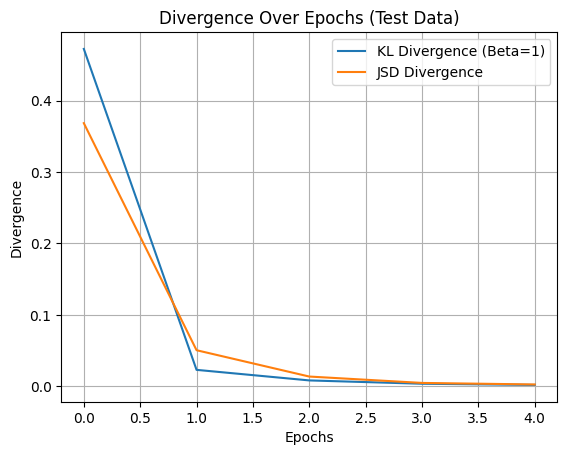

=== Average Divergence Metrics ===
Average KL (Beta=1): 0.101885
Average JSD        : 0.088042

Evaluating model and generating predictions...


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

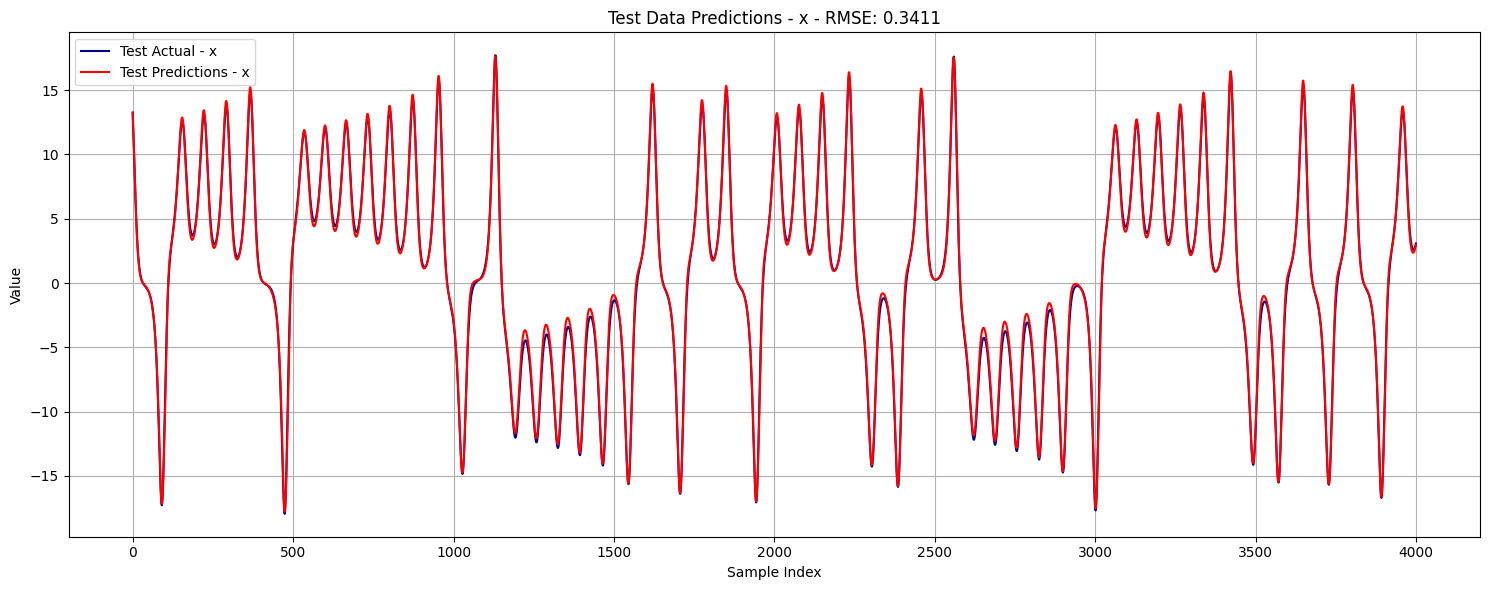

<Figure size 1500x800 with 0 Axes>

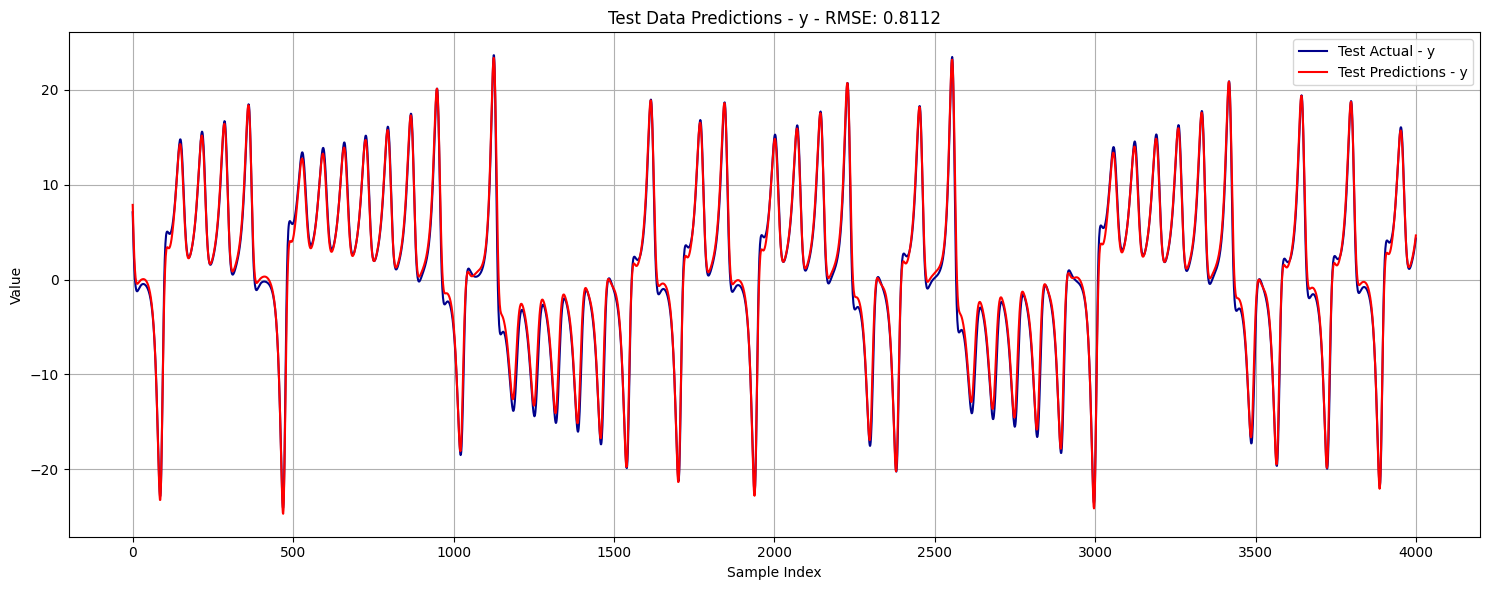

<Figure size 1500x800 with 0 Axes>

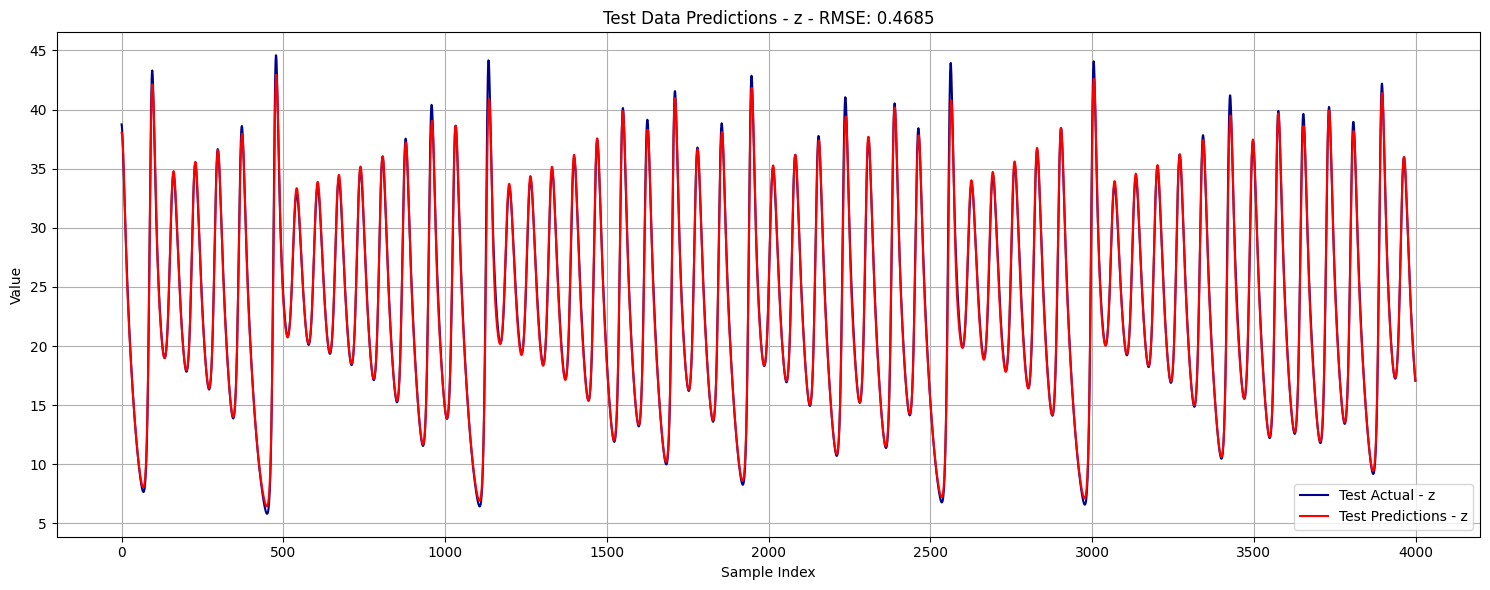


Metrics for x:
Training RMSE: 0.3975
Test RMSE: 0.3411
Training RMSE (Scaled): 0.0206
Test RMSE (Scaled): 0.0177

Metrics for y:
Training RMSE: 0.9244
Test RMSE: 0.8112
Training RMSE (Scaled): 0.0347
Test RMSE (Scaled): 0.0304

Metrics for z:
Training RMSE: 0.5197
Test RMSE: 0.4685
Training RMSE (Scaled): 0.0215
Test RMSE (Scaled): 0.0194

Average Metrics Across All Targets:
Avg Training RMSE: 0.6139
Avg Test RMSE: 0.5403
Training RMSE: 0.3975
Test RMSE: 0.3411
Skipping Lyapunov exponent calculation as requested.


In [233]:
csv_path = 'lorenz6.csv'  # Update to your file path


hyperparameter_sets = [

    {'alpha':-9999, 'beta': -999, 'n': -99, 'seq_length': 40}
]


for hparams in hyperparameter_sets:
    print('\n\n\n\n\n')
    print("Below Model uses ", hparams)
    use_custom_lstm = False # Set to False to use BaselineMultivariateLSTM

    # Call train_from_csv explicitly, conditionally including alpha, beta, n
    if use_custom_lstm:
        model, results, history = train_from_csv(
            csv_path=csv_path,
            feature_column=['x', 'y', 'z'],  # Use multiple features
            target_column=None,
            date_column='time',
            seq_length=hparams['seq_length'],
            hidden_size=64,
            epochs=5,
            use_custom_lstm=use_custom_lstm,
            alpha=hparams['alpha'],
            beta=hparams['beta'],
            n=hparams['n']
        )
    else:
         model, results, history = train_from_csv(
            csv_path=csv_path,
            feature_column=['x', 'y', 'z'],  # Use multiple features
            target_column=None,
            date_column='time',
            seq_length=hparams['seq_length'],
            hidden_size=64,
            epochs=5,
            use_custom_lstm=use_custom_lstm
        )


    # Removed Lyapunov exponent calculation
    print("Skipping Lyapunov exponent calculation as requested.")